In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import maze_plot as mplot

from maze_task import Maze2D

from tqdm.notebook import trange, tqdm
import colorama
from bayes_opt import BayesianOptimization


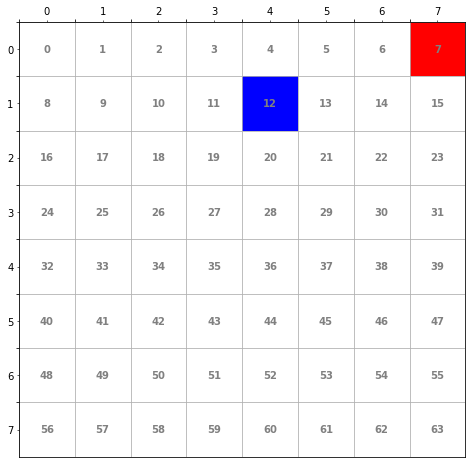

In [2]:
size = (4,4)

maze = Maze2D(size)
maze.agent_pos = 12
maze.move_reward(next_pos=7)

fig, ax = mplot.base_fig(size)
mplot.draw_cell_numbers(ax, maze.maze_array)
mplot.color_square(ax, maze.get_coordinates(maze.agent_pos), 'b')
mplot.color_square(ax, maze.get_coordinates(maze.reward_pos), 'r')

In [3]:
def generate_episode(maze, policy_w):
    
    s = []
    a = []
    r = []
    
    R = 0.0
    
    while R==0.0:
        state = tf.one_hot(maze.agent_pos, maze.tot_room_number, dtype=tf.float32)
        s.append(maze.agent_pos)
        
        y = tf.linalg.matvec(policy_w, state)
        action = np.random.choice(np.arange(4), p=tf.nn.softmax(y).numpy())
        a.append(action)
        
        new_state, R = maze.perform_action(action, proba_opposite=pr_opp, proba_others=pr_oth)
        r.append(R)
        
        maze.agent_pos = new_state
        
        if len(s)>max_episode_length+1:
            break
        
    return s,a,r

##### Training loop

In [4]:
tot_episodes = 1000
tot_trials_per_params = 50

max_fails = 50

def train_loop(gamma, log_lr, opt=True):
      
    lr = 10**log_lr

    maze.agent_pos = maze.get_random_position()

    tot_states = maze.tot_room_number
    tot_actions = 4

    tot_steps_per_params = []

    with trange(tot_trials_per_params, desc='repeat loop', position = 0) as t2:
        for _ in t2:
            tot_steps = []

            W_pi = tf.Variable(np.zeros((tot_actions, tot_states)), dtype=tf.float32, trainable=True)
            W_v = tf.Variable(np.zeros((1, tot_states)), dtype=tf.float32, trainable=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

            fail_count = 0
            
            with trange(tot_episodes, desc='inner loop', position=1, leave=False) as t:
                for e in t:
                    critic_loss = 0.0
                    actor_loss = 0.0
                    
                    # Generate episode
                    s,a,r = generate_episode(maze, tf.stop_gradient(W_pi))
                    if len(s) > max_episode_length:
                        tot_steps.append(max_episode_length)
                        fail_count+=1
                        if fail_count>max_fails:
                            tot_steps = [max_episode_length]*tot_episodes
                            t.close()
                            break
                        else:
                            continue
                    tot_steps.append(len(s))
                    t.set_postfix(total_steps=len(s), fails=fail_count)                        
                    
                    # if generated episode is ok, train
                    
                    with tf.GradientTape() as tape:
                        for step, _ in enumerate(s):                            
                            time_to_t = len(s) - step
                            R = gamma**time_to_t * r[-1]
                            
                            state = tf.one_hot(s[step], maze.tot_room_number, dtype=tf.float32)
                            action = tf.one_hot(a[step], maze.tot_room_number, dtype=tf.float32)

                            critic_loss += (tf.linalg.matvec(W_v, state) - R)**2
                            stop_grad = tf.stop_gradient(tf.linalg.matvec(W_v, state) - R)
                            pi = tf.nn.softmax(tf.linalg.matvec(W_pi, state))
                            actor_loss += tf.math.log(pi[a[step]])*stop_grad

                        loss = actor_loss + critic_loss
                        grads = tape.gradient(loss, [W_v, W_pi])
                        optimizer.apply_gradients(zip(grads, [W_v, W_pi]))

                    maze.agent_pos = maze.get_random_position()

            tot_steps_per_params.append(np.array(tot_steps))
            if fail_count>10:
                print(f'FAIL, tot_steps_per_params: {tot_steps_per_params}')

    tot_steps_per_params = np.array(tot_steps_per_params)
    avg_steps = tot_steps_per_params.mean(axis=0)
    cumulated_steps = avg_steps.sum()
    
    if opt is True:
        return -cumulated_steps
    else:
        return W_v, W_pi, tot_steps_per_params

## Deterministic actions

In [6]:
pr_opp=0.0
pr_oth=0.0
max_episode_length = 1500
W_v_nostoch, W_pi_nostoch, tot_steps_per_params = train_loop(gamma=0.9, log_lr=-2.0, opt=False)

Text(0.5, 1.0, 'total steps to reach reward')

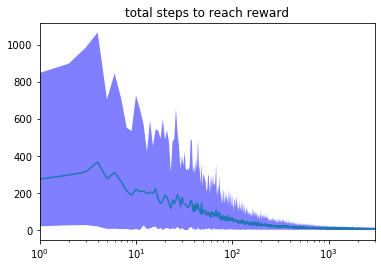

In [7]:
avg_steps_nostoch = tot_steps_per_params.mean(axis=0)
low_steps_nostoch = np.percentile(tot_steps_per_params, 5 ,axis=0)
high_steps_nostoch = np.percentile(tot_steps_per_params, 95 ,axis=0)

plt.plot(avg_steps_nostoch)
plt.fill_between(np.arange(len(avg_steps_nostoch)), high_steps_nostoch, low_steps_nostoch, facecolor='blue', alpha=0.5)
plt.xscale('log')
plt.xlim([1,len(avg_steps_nostoch)])
plt.title('total steps to reach reward')

In [ ]:
values=[]

for room in range(maze.tot_room_number):
    state = tf.one_hot(room, maze.tot_room_number, dtype=tf.float32)
    values.append(f"{tf.linalg.matvec(W_v_nostoch, state).numpy()[0]:.2f}")
    
values_nostoch = np.array(values).reshape(size[0],size[1])

In [ ]:
# best action according to pi
size = (8,8)
fig, ax = mplot.base_fig(size)
mplot.draw_cell_numbers(ax, values_nostoch)

for room in range(maze.tot_room_number):
    state = tf.one_hot(room, maze.tot_room_number, dtype=tf.float32)
    best_action = tf.math.argmax(tf.linalg.matvec(W_pi_nostoch, state)).numpy()
    _, next_state = maze.step(room, maze.moves_list[best_action])
    mplot.draw_arrow(ax, maze.get_coordinates(room), next_state, color='r')

In [ ]:
gamma = 0.8829873789358123
_ = [print(gamma**t) for t in range(7)] 

In [ ]:
# pbounds = {'gamma': (0.80, 0.999), 'log_lr': (-3.0, 0.0)}

# optimizer = BayesianOptimization(
#     f=train_loop,
#     pbounds=pbounds,
#     random_state=1,
# )

# optimizer.maximize(
#     init_points=2,
#     n_iter=10,
# )

## Slightly stochastic actions

In [ ]:
pr_opp=0.10
pr_oth=0.10
max_episode_length = 1500
W_v_stoch, W_pi_stoch, tot_steps_per_params = train_loop(gamma=0.8829873789358123, log_lr=-0.8390265196735256, opt=False)

In [ ]:
avg_steps_stoch = tot_steps_per_params.mean(axis=0)
low_steps_stoch = np.percentile(tot_steps_per_params, 5 ,axis=0)
high_steps_stoch = np.percentile(tot_steps_per_params, 95 ,axis=0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(avg_steps_stoch)
ax1.fill_between(np.arange(len(avg_steps_stoch)), high_steps_stoch, low_steps_stoch, facecolor='blue', alpha=0.5)
ax1.set_xscale('log')
ax1.set_xlim([1,len(avg_steps_stoch)])
ax1.set_title('Stochastic actions')

ax2.plot(avg_steps_nostoch)
ax2.fill_between(np.arange(len(avg_steps_nostoch)), high_steps_nostoch, low_steps_nostoch, facecolor='blue', alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlim([1,len(avg_steps_nostoch)])
ax2.set_ylim(ax1.get_ylim())
ax2.set_title('Deterministic actions')

In [ ]:
values=[]

for room in range(maze.tot_room_number):
    state = tf.one_hot(room, maze.tot_room_number, dtype=tf.float32)
    values.append(f"{tf.linalg.matvec(W_v_stoch, state).numpy()[0]:.2f}")
    
values_stoch = np.array(values).reshape(size[0],size[1])

size = (8,8)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,5))

# best action according to pi

mplot.base_fig(size, ax1)
mplot.draw_cell_numbers(ax1, values_stoch)
ax1.set_title('Stochastic actions')

for room in range(maze.tot_room_number):
    state = tf.one_hot(room, maze.tot_room_number, dtype=tf.float32)
    best_action = tf.math.argmax(tf.linalg.matvec(W_pi_stoch, state)).numpy()
    _, next_state = maze.step(room, maze.moves_list[best_action])
    mplot.draw_arrow(ax1, maze.get_coordinates(room), next_state, color='r')
    
mplot.base_fig(size, ax2)
mplot.draw_cell_numbers(ax2, values_nostoch)
ax2.set_title('Deterministic actions')

for room in range(maze.tot_room_number):
    state = tf.one_hot(room, maze.tot_room_number, dtype=tf.float32)
    best_action = tf.math.argmax(tf.linalg.matvec(W_pi_nostoch, state)).numpy()
    _, next_state = maze.step(room, maze.moves_list[best_action])
    mplot.draw_arrow(ax2, maze.get_coordinates(room), next_state, color='r')

In [ ]:
state = tf.one_hot(12, maze.tot_room_number, dtype=tf.float32)
tf.linalg.matvec(W_pi_stoch, state).numpy()

In [ ]:



gamma = 0.8829873789358123
_ = [print(gamma**t) for t in range(7)] 

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib import mlab
# from matplotlib import gridspec
# %matplotlib inline



# def unique_rows(a):
#     """
#     A functions to trim repeated rows that may appear when optimizing.
#     This is necessary to avoid the sklearn GP object from breaking

#     :param a: array to trim repeated rows from

#     :return: mask of unique rows
#     """

#     # Sort array and kep track of where things should go back to
#     order = np.lexsort(a.T)
#     reorder = np.argsort(order)

#     a = a[order]
#     diff = np.diff(a, axis=0)
#     ui = np.ones(len(a), 'bool')
#     ui[1:] = (diff != 0).any(axis=1)

#     return ui[reorder]

# x = np.linspace(0.0, 2.0, 300)
# y = np.linspace(-3.0, 0.0, 300)
# X, Y = np.meshgrid(x, y)
# x = X.ravel()
# y = Y.ravel()
# # X = np.vstack([x, y]).T[:, [1, 0]]
# X = np.vstack([x, y]).T[:, [0, 1]]

# def posterior(bo, X):
# #     ur = unique_rows(bo.X)
#     bo._gp.fit(bo._space.params, bo._space.target)
#     mu, sigma2 = bo._gp.predict(X, return_std=True)
#     return mu, np.sqrt(sigma2)

# def plot_2d(name=None):

#     mu, s = posterior(bo, X)

#     print(mu, s)
    
#     fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#     gridsize=150

#     # fig.suptitle('Bayesian Optimization in Action', fontdict={'size':30})

#     # GP regression output
#     ax[0].set_title('Gaussian Process Predicted Mean', fontdict={'size':15})
#     im00 = ax[0].hexbin(x, y, C=mu, gridsize=gridsize, cmap=cm.jet, bins=None)
#     ax[0].axis([x.min(), x.max(), y.min(), y.max()])
#     ax[0].plot(bo._space.params[:, 1], bo._space.params[:, 0], 'D', markersize=4, color='k', label='Observations')


#     ax[1].set_title('Gausian Process Variance', fontdict={'size':15})
#     im01 = ax[1].hexbin(x, y, C=s, gridsize=gridsize, cmap=cm.jet, bins=None)
#     ax[1].axis([x.min(), x.max(), y.min(), y.max()])


#     for im, axis in zip([im00, im01], ax.flatten()):
#         cb = fig.colorbar(im, ax=axis)
#         # cb.set_label('Value')

#     if name is None:
#         name = '_'

#     plt.tight_layout()

#     # Save or show figure?
#     # fig.savefig('bo_eg_' + name + '.png')
#     plt.show()


# # plot_2d("test")

In [ ]:
# pbounds = {'gamma': (0.0, 1.99), 'log_lr': (-3.0, 0.0)}

# bo = BayesianOptimization(
#     f=train_loop,
#     pbounds=pbounds
# #     random_state=1,
# )

# bo.maximize(
#     init_points=3,
#     n_iter=0,
# #     kappa=250,
#     normalize_y=True
# )

In [ ]:
# plot_2d("test")

In [ ]:
2328.75

In [ ]:
# bo._gp.predict([[ 0.883, -0.839]], return_std=True)

In [ ]:
# Xtemp = X[:,0].copy()
# X[:,0] = X[:,1].copy()
# X[:,1] = Xtemp
# X

In [ ]:
# aa,bb = bo._gp.predict(X, return_std=True)